In [1]:
!pip install transformers
!pip install pandas
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 40.7 MB/s eta 0:00:00


In [2]:
from scipy.stats import pearsonr
from transformers import BertTokenizer, TFBertModel
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.metrics

# **Read in data and preprocess**

In [3]:
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')

In [4]:
df = pd.read_table("lcp_single_train.tsv", keep_default_na=False, quoting=3)

In [5]:
random.seed(0)
random_train_indexes = random.sample(range(len(df)), 4000)

In [6]:
sentence_array = []
token_array = []
output_array = []

# for i in range(len(df)):
#   sentence_array.append(df.iloc[i]['sentence'])
#   token_array.append(df.iloc[i]['token'])
#   output_array.append(df.iloc[i]['complexity'])

for i in random_train_indexes:
  sentence_array.append(df.iloc[i]['sentence'])
  token_array.append(df.iloc[i]['token'])
  output_array.append(df.iloc[i]['complexity'])

preprocessed_sentence_array = preprocess.tokenize(sentence_array)
preprocessed_token_array = preprocess.tokenize(token_array)
encoder_inputs = preprocess.bert_pack_inputs([preprocessed_sentence_array, preprocessed_token_array])
outputs_as_tensor = tf.convert_to_tensor(output_array)

Graphic of encoder input. Yellow = sentence content, Purple = pad characters

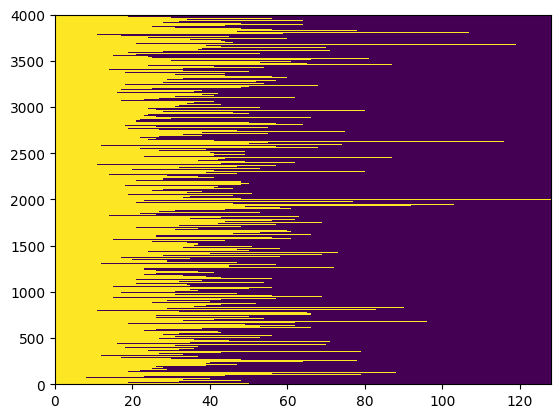

In [7]:
plt.pcolormesh(encoder_inputs['input_mask'])

Two strings were "packed" into a single input and padded up to a length of 128. First purple region on left = full sentences
Yellow region = target token word to predict complexity on
Second purple region on right = pad characters

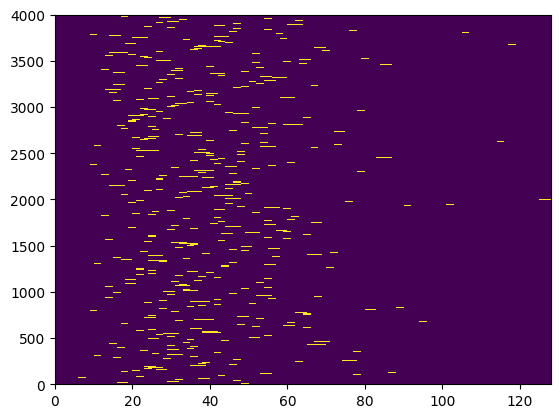

In [8]:
plt.pcolormesh(encoder_inputs['input_type_ids'])

In [9]:
test_df = pd.read_table("lcp_single_test.tsv", keep_default_na=False, quoting=3)
# test_df = pd.read_table("lcp_multi_test_no_quotes.tsv", keep_default_na=False)
sentence_array_test = []
token_array_test = []
output_array_test = []

for i in range(len(test_df)):
  sentence_array_test.append(test_df.iloc[i]['sentence'])
  token_array_test.append(test_df.iloc[i]['token'])
  output_array_test.append(test_df.iloc[i]['complexity'])

preprocessed_sentence_array_test = preprocess.tokenize(sentence_array_test)
preprocessed_token_array_test = preprocess.tokenize(token_array_test)
encoder_inputs_test = preprocess.bert_pack_inputs([preprocessed_sentence_array_test, preprocessed_token_array_test])
outputs_as_tensor_test = tf.convert_to_tensor(output_array_test)

# **Pre-trained BERT**

In [10]:
def build_bert_regression_model():

  class BERT_Regression(tf.keras.Model):
    def __init__(self):
      super(BERT_Regression, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(1, activation='sigmoid', name="output")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = BERT_Regression()
  return model

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
bert_model = build_bert_regression_model()
bert_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [16]:
history = bert_model.fit(encoder_inputs, outputs_as_tensor, batch_size=32, epochs=10, callbacks=[callback], validation_split=0.1)

Epoch 1/10
113/113 [==============================] - 94s 833ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 2/10
113/113 [==============================] - 94s 832ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 3/10
113/113 [==============================] - 94s 832ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 4/10
113/113 [==============================] - 94s 832ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 5/10
113/113 [==============================] - 94s 832ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0085 - val_mean_squared_error: 0.0085


In [86]:
bert_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  109482241 
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 output (Dense)              multiple                  769       
                                                                 
Total params: 109,483,010
Trainable params: 109,483,009
Non-trainable params: 1
_________________________________________________________________


In [82]:
# Save the weights
bert_model.save_weights('./checkpoints/bert')

In [17]:
out_test_data_bert = bert_model.predict(encoder_inputs_test)

29/29 [==============================] - 8s 280ms/step


In [18]:
pearsonr(np.reshape(out_test_data_bert, len(out_test_data_bert)), output_array_test)

PearsonRResult(statistic=0.734027120806187, pvalue=6.111555176577056e-156)

In [19]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_bert, len(out_test_data_bert)))

0.4661251837135094

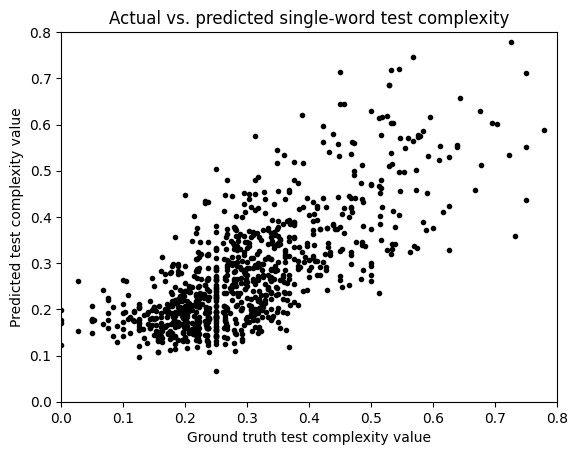

In [20]:
plt.plot(output_array_test, np.reshape(out_test_data_bert, len(out_test_data_bert)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted single-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

**Test data and prediction analysis**

Test mean, median, std dev follow similar patterns as train data

In [21]:
bible_test_idx = np.where(test_df['corpus']=='bible')
biomed_test_idx = np.where(test_df['corpus']=='biomed')
europarl_test_idx = np.where(test_df['corpus']=='europarl')

In [22]:
print('Bible test points mean: ' + str(np.mean(np.array(output_array_test)[bible_test_idx])))
print('Biomed test points mean: ' + str(np.mean(np.array(output_array_test)[biomed_test_idx])))
print('Europarl test points mean: ' + str(np.mean(np.array(output_array_test)[europarl_test_idx])))
print('Bible test points variance: ' + str(np.var(np.array(output_array_test)[bible_test_idx])))
print('Biomed test points variance: ' + str(np.var(np.array(output_array_test)[biomed_test_idx])))
print('Europarl test points variance: ' + str(np.var(np.array(output_array_test)[europarl_test_idx])))



Bible test points mean: 0.2921192975390453
Biomed test points mean: 0.31715872597842354
Europarl test points mean: 0.28242137860165695
Bible test points variance: 0.016868932495656186
Biomed test points variance: 0.022069430389190264
Europarl test points variance: 0.010123494261653562


Pearson correlation and R2 separated by corpus. Best predictive capability on biomed sentences

In [23]:
print(pearsonr(np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
print(pearsonr(np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
print(pearsonr(np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

PearsonRResult(statistic=0.7164053876517319, pvalue=7.74025651561897e-46)
PearsonRResult(statistic=0.7723843784749368, pvalue=1.6230573430985504e-58)
PearsonRResult(statistic=0.6677049231163309, pvalue=6.960422804287546e-46)


In [24]:
print(sklearn.metrics.r2_score(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx]))))

0.4361947924196131
0.5361259454121323
0.3490692751342399


Predicted values on average were just above one point off from actuals on 5-point complexity scale (0.25 on 0 to 1 scale) 

In [25]:
bible_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
biomed_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
europarl_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

print("Average absolute difference, predicted vs. actual:\n  Bible:  " + 
      str(bible_avg_abs_diff) + "\n  Biomed:  " + 
      str(biomed_avg_abs_diff) + "\n  Europarl:  " +
      str(europarl_avg_abs_diff))

Average absolute difference, predicted vs. actual:
  Bible:  0.26993895214143154
  Biomed:  0.30109967935869025
  Europarl:  0.2639966067844543


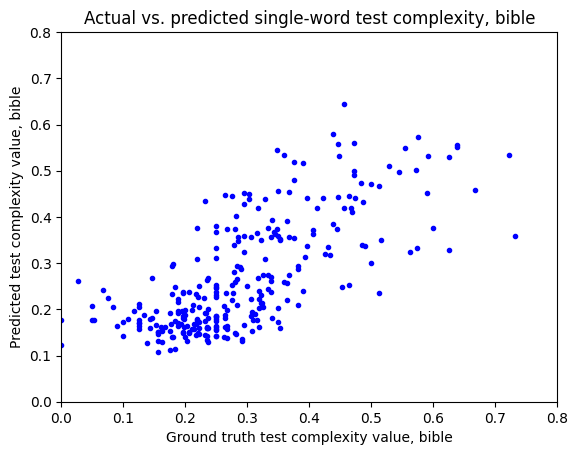

In [26]:
plt.plot(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx])), 'b.')
plt.xlabel("Ground truth test complexity value, bible")
plt.ylabel("Predicted test complexity value, bible")
plt.title("Actual vs. predicted single-word test complexity, bible")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()


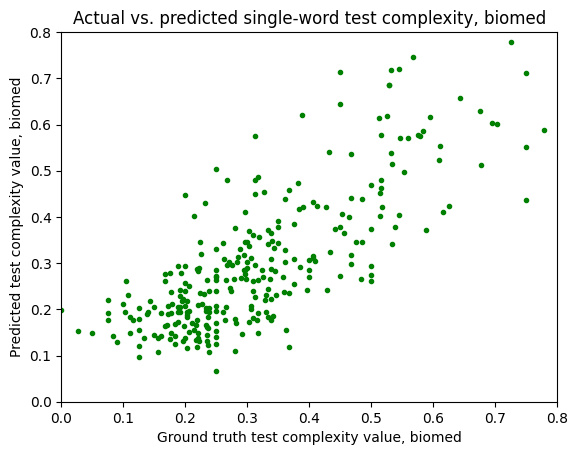

In [27]:
plt.plot(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx])), 'g.')
plt.xlabel("Ground truth test complexity value, biomed")
plt.ylabel("Predicted test complexity value, biomed")
plt.title("Actual vs. predicted single-word test complexity, biomed")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()


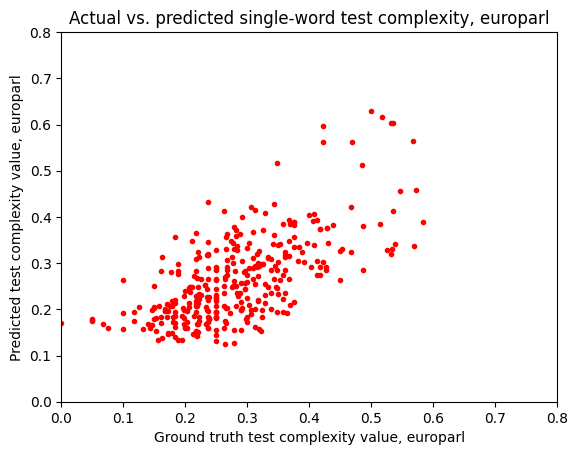

In [28]:
plt.plot(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx])), 'r.')
plt.xlabel("Ground truth test complexity value, europarl")
plt.ylabel("Predicted test complexity value, europarl")
plt.title("Actual vs. predicted single-word test complexity, europarl")
plt.xlim([0,0.8])
plt.ylim([0,0.8])

plt.show()

# **BERT Expert pretrained on Medical corpus**




In [29]:
def build_bert_medical_model():

  class BERT_Medical_Regression(tf.keras.Model):
    def __init__(self):
      super(BERT_Medical_Regression, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer("https://tfhub.dev/google/experts/bert/pubmed/2", trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(1, activation='sigmoid', name="output")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = BERT_Medical_Regression()
  return model

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
bert_medical_model = build_bert_medical_model()
bert_medical_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [31]:
bert_medical_model_history = bert_medical_model.fit(encoder_inputs, outputs_as_tensor, batch_size=32, epochs=10, callbacks=[callback], validation_split=0.1)

Epoch 1/10
113/113 [==============================] - 138s 855ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 2/10
113/113 [==============================] - 96s 849ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 3/10
113/113 [==============================] - 96s 848ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 4/10
113/113 [==============================] - 96s 848ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 5/10
113/113 [==============================] - 96s 851ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 6/10
113/113 [==============================] - 96s 851ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 7/1

In [87]:
bert_medical_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  109482241 
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 output (Dense)              multiple                  769       
                                                                 
Total params: 109,483,010
Trainable params: 109,483,009
Non-trainable params: 1
_________________________________________________________________


In [32]:
out_test_data_bert_medical = bert_medical_model.predict(encoder_inputs_test)

29/29 [==============================] - 8s 278ms/step


In [33]:
pearsonr(np.reshape(out_test_data_bert_medical, len(out_test_data_bert_medical)), output_array_test)

PearsonRResult(statistic=0.7118800960943449, pvalue=1.3710884456409825e-142)

In [34]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_bert_medical, len(out_test_data_bert_medical)))

0.49265925784047604

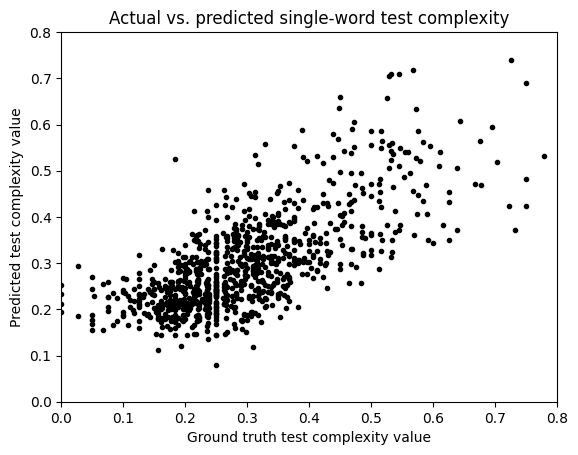

In [36]:
plt.plot(output_array_test, np.reshape(out_test_data_bert_medical, len(out_test_data_bert_medical)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted single-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

In [37]:
print(pearsonr(np.reshape(out_test_data_bert_medical[bible_test_idx], len(out_test_data_bert_medical[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
print(pearsonr(np.reshape(out_test_data_bert_medical[biomed_test_idx], len(out_test_data_bert_medical[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
print(pearsonr(np.reshape(out_test_data_bert_medical[europarl_test_idx], len(out_test_data_bert_medical[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

PearsonRResult(statistic=0.6665287310888836, pvalue=1.0136546177205728e-37)
PearsonRResult(statistic=0.7731366300568434, pvalue=1.0716509787547744e-58)
PearsonRResult(statistic=0.6460570536491681, pvalue=3.8398813505240644e-42)


In [38]:
print(sklearn.metrics.r2_score(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_bert_medical[bible_test_idx], len(out_test_data_bert_medical[bible_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_bert_medical[biomed_test_idx], len(out_test_data_bert_medical[biomed_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_bert_medical[europarl_test_idx], len(out_test_data_bert_medical[europarl_test_idx]))))

0.4284829212104324
0.5902375759882987
0.373549391340127


# **Electra**

In [39]:
def build_electra_model():

  class Electra_Regression(tf.keras.Model):
    def __init__(self):
      super(Electra_Regression, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer("https://tfhub.dev/google/electra_base/2", trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(1, activation='sigmoid', name="output")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Electra_Regression()
  return model

In [44]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
electra_model = build_electra_model()
electra_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [45]:
electra_model_history = electra_model.fit(encoder_inputs, outputs_as_tensor, batch_size=32, epochs=10, callbacks=[callback], validation_split=0.1)

Epoch 1/10
113/113 [==============================] - 137s 861ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 2/10
113/113 [==============================] - 97s 855ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 3/10
113/113 [==============================] - 97s 855ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 4/10
113/113 [==============================] - 96s 853ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 5/10
113/113 [==============================] - 96s 852ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 6/10
113/113 [==============================] - 96s 853ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 7/1

In [42]:
electra_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  multiple                  109482241 
                                                                 
 dropout_7 (Dropout)         multiple                  0         
                                                                 
 output (Dense)              multiple                  769       
                                                                 
Total params: 109,483,010
Trainable params: 109,483,009
Non-trainable params: 1
_________________________________________________________________


In [46]:
out_test_data_electra = electra_model.predict(encoder_inputs_test)

29/29 [==============================] - 8s 278ms/step


In [47]:
pearsonr(np.reshape(out_test_data_electra, len(out_test_data_electra)), output_array_test)

PearsonRResult(statistic=0.6639813679818757, pvalue=1.2162233460950274e-117)

In [48]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_bert_medical, len(out_test_data_bert_medical)))

0.49265925784047604

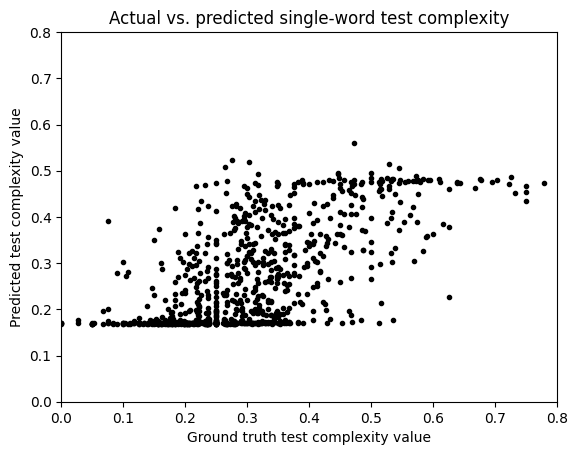

In [98]:
plt.plot(output_array_test, np.reshape(out_test_data_electra, len(out_test_data_electra)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted single-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

In [100]:
print(pearsonr(np.reshape(out_test_data_electra[bible_test_idx], len(out_test_data_electra[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
print(pearsonr(np.reshape(out_test_data_electra[biomed_test_idx], len(out_test_data_electra[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
print(pearsonr(np.reshape(out_test_data_electra[europarl_test_idx], len(out_test_data_electra[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

PearsonRResult(statistic=0.6630147982218249, pvalue=3.3034509330872794e-37)
PearsonRResult(statistic=0.7175847670896814, pvalue=5.352380388291585e-47)
PearsonRResult(statistic=0.5674386577173295, pvalue=8.606112988390204e-31)


In [101]:
print(sklearn.metrics.r2_score(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_electra[bible_test_idx], len(out_test_data_electra[bible_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_electra[biomed_test_idx], len(out_test_data_electra[biomed_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_electra[europarl_test_idx], len(out_test_data_electra[europarl_test_idx]))))

0.27657031391054687
0.4578846973540347
0.11064940342842133


# **ALBERT**

In [51]:
def build_albert_model():

  class Albert_Regression(tf.keras.Model):
    def __init__(self):
      super(Albert_Regression, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3", trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(1, activation='sigmoid', name="output")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Albert_Regression()
  return model

In [71]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
albert_model = build_albert_model()
albert_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [72]:
albert_model_history = albert_model.fit(encoder_inputs, outputs_as_tensor, batch_size=32, epochs=10, callbacks=[callback], validation_split=0.1)

Epoch 1/10
113/113 [==============================] - 127s 1s/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 2/10
113/113 [==============================] - 116s 1s/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 3/10
113/113 [==============================] - 116s 1s/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 4/10
113/113 [==============================] - 116s 1s/step - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 5/10
113/113 [==============================] - 116s 1s/step - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 6/10
113/113 [==============================] - 116s 1s/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0180 - val_mean_squared_error: 0.0180


In [54]:
albert_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  multiple                  11683584  
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 output (Dense)              multiple                  769       
                                                                 
Total params: 11,684,353
Trainable params: 11,684,353
Non-trainable params: 0
_________________________________________________________________


In [73]:
out_test_data_albert = albert_model.predict(encoder_inputs_test)

29/29 [==============================] - 8s 273ms/step


In [74]:
pearsonr(np.reshape(out_test_data_albert, len(out_test_data_albert)), output_array_test)

PearsonRResult(statistic=-0.038995385606906595, pvalue=0.2381209066368515)

In [85]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_albert, len(out_test_data_albert)))

-3.656493382031556e-05

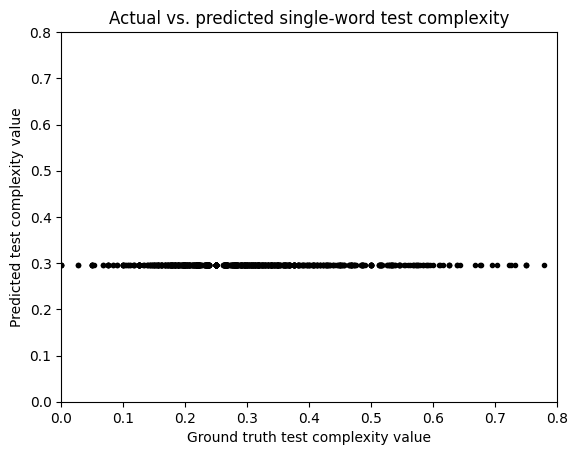

In [99]:
plt.plot(output_array_test, np.reshape(out_test_data_albert, len(out_test_data_albert)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted single-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

# **Ensembling**

Averaging the outputs of the three models that converged: English BERT, BERT pretrained on a medical corpus, and Electra. The first two were able to achieve lower val loss so were given 2x weight.

In [105]:
out_test_data_avg = (2*out_test_data_bert + 2*out_test_data_bert_medical + out_test_data_electra) / 5

In [106]:
pearsonr(np.reshape(out_test_data_avg, len(out_test_data_avg)), output_array_test)

PearsonRResult(statistic=0.7428460894878148, pvalue=1.2279923367281458e-161)

In [107]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_avg, len(out_test_data_avg)))

0.5291970522150713

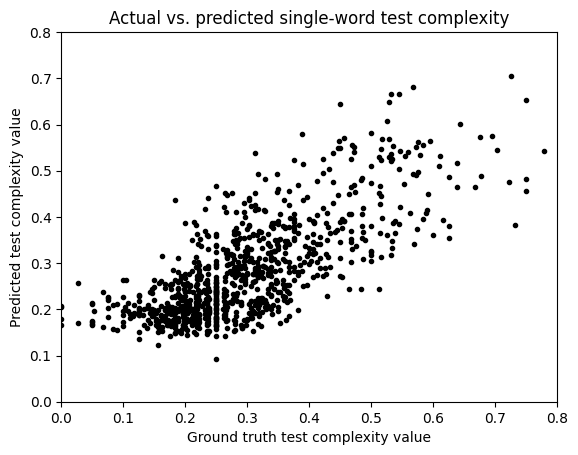

In [76]:
plt.plot(output_array_test, np.reshape(out_test_data_avg, len(out_test_data_avg)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted single-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

Test mean, median, std dev follow similar patterns as train data

In [97]:
print('Bible test points mean: ' + str(np.mean(np.array(output_array_test)[bible_test_idx])))
print('Biomed test points mean: ' + str(np.mean(np.array(output_array_test)[biomed_test_idx])))
print('Europarl test points mean: ' + str(np.mean(np.array(output_array_test)[europarl_test_idx])))
print('Bible test points variance: ' + str(np.var(np.array(output_array_test)[bible_test_idx])))
print('Biomed test points variance: ' + str(np.var(np.array(output_array_test)[biomed_test_idx])))
print('Europarl test points variance: ' + str(np.var(np.array(output_array_test)[europarl_test_idx])))

Bible test points mean: 0.2921192975390453
Biomed test points mean: 0.31715872597842354
Europarl test points mean: 0.28242137860165695
Bible test points variance: 0.016868932495656186
Biomed test points variance: 0.022069430389190264
Europarl test points variance: 0.010123494261653562


Pearson correlation and R2 separated by corpus. Best predictive capability on biomed sentences

In [81]:
print(pearsonr(np.reshape(out_test_data_avg[bible_test_idx], len(out_test_data_avg[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
print(pearsonr(np.reshape(out_test_data_avg[biomed_test_idx], len(out_test_data_avg[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
print(pearsonr(np.reshape(out_test_data_avg[europarl_test_idx], len(out_test_data_avg[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

PearsonRResult(statistic=0.7195117308071758, pvalue=2.1143785081788464e-46)
PearsonRResult(statistic=0.7880430502462811, pvalue=2.032060894516182e-62)
PearsonRResult(statistic=0.6741289716576379, pvalue=4.686837372850611e-47)


In [82]:
print(sklearn.metrics.r2_score(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx]))))

0.4361947924196131
0.5361259454121323
0.3490692751342399


Predicted values on average were just above one point off from actuals on 5-point complexity scale (0.25 on 0 to 1 scale) 

In [83]:
bible_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
biomed_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
europarl_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

print("Average absolute difference, predicted vs. actual:\n  Bible:  " + 
      str(bible_avg_abs_diff) + "\n  Biomed:  " + 
      str(biomed_avg_abs_diff) + "\n  Europarl:  " +
      str(europarl_avg_abs_diff))

Average absolute difference, predicted vs. actual:
  Bible:  0.26993895214143154
  Biomed:  0.30109967935869025
  Europarl:  0.2639966067844543


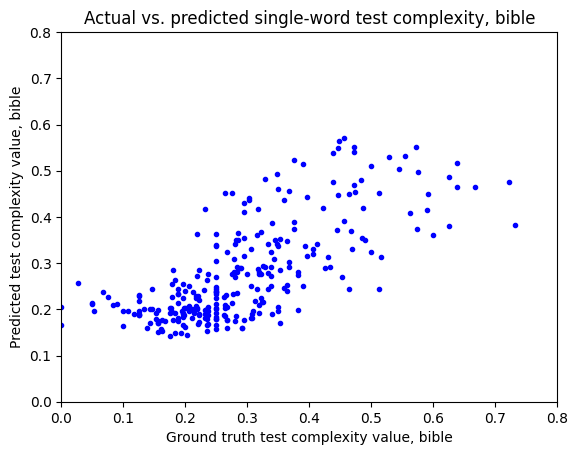

In [77]:
plt.plot(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_avg[bible_test_idx], len(out_test_data_avg[bible_test_idx])), 'b.')
plt.xlabel("Ground truth test complexity value, bible")
plt.ylabel("Predicted test complexity value, bible")
plt.title("Actual vs. predicted single-word test complexity, bible")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

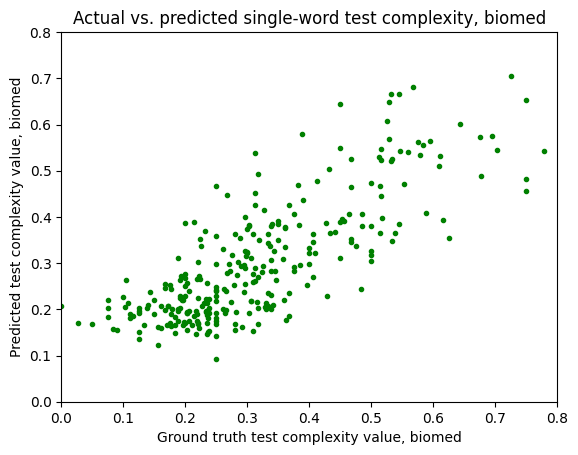

In [78]:
plt.plot(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_avg[biomed_test_idx], len(out_test_data_avg[biomed_test_idx])), 'g.')
plt.xlabel("Ground truth test complexity value, biomed")
plt.ylabel("Predicted test complexity value, biomed")
plt.title("Actual vs. predicted single-word test complexity, biomed")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()


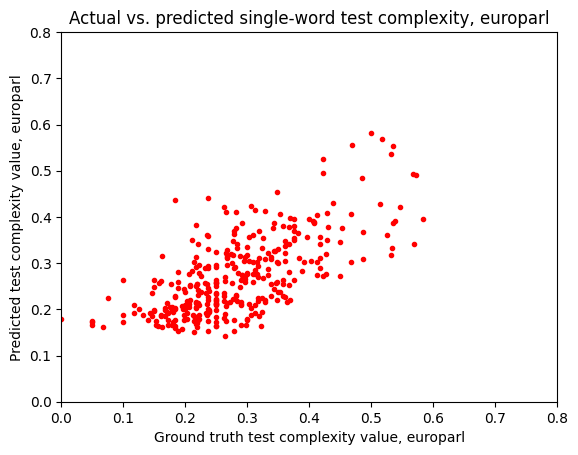

In [79]:
plt.plot(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_avg[europarl_test_idx], len(out_test_data_avg[europarl_test_idx])), 'r.')
plt.xlabel("Ground truth test complexity value, europarl")
plt.ylabel("Predicted test complexity value, europarl")
plt.title("Actual vs. predicted single-word test complexity, europarl")
plt.xlim([0,0.8])
plt.ylim([0,0.8])

plt.show()